In [1]:
using MultivariateStats
using DifferentialEquations
using Plots
gr(fmt="png", size=(1600, 600))

include("../src/HHModel.jl")

# stimulus protocol
current_step = (t, param) -> begin
    (param.start < t)&(t < param.dur + param.start) ? param.step + param.holding + param.noise * randn() : param.holding + param.holding + param.noise * randn()
end

In [61]:
# type one in matlab

# biophysical model setup ==> usu. for maximum conductance
htk = HHModel.high_voltage_gated_potassium(2.8)
ltk = HHModel.low_voltage_gated_potassium(0.65, subtype=:ikcnq)
# ik = HHModel.hh_potassium(10.0)
ina = HHModel.hh_sodium(20.0)
ih = HHModel.ihcurrent(0.91)
il = HHModel.leakage(0.03)

_model = [htk, ltk, ina, ih, il]
# _model = [htk, ina, ih, il]
_model_sim_cc = HHModel.simpleConductanceModel(_model, current_step, C=0.9); # current clamp

In [69]:
# type two in matlab

# biophysical model setup ==> usu. for maximum conductance
htk = HHModel.high_voltage_gated_potassium(2.8)
ltk = HHModel.low_voltage_gated_potassium(1.1, subtype=:kv1)
# ik = HHModel.hh_potassium(10.0)
ina = HHModel.hh_sodium(13.0)
ih = HHModel.ihcurrent(0.43)
il = HHModel.leakage(0.03)

_model = [htk, ltk, ina, ih, il]
# _model = [htk, ina, ih, il]
_model_sim_cc = HHModel.simpleConductanceModel(_model, current_step, C=0.9); # current clamp

  0.694714 seconds (4.82 M allocations: 667.259 MiB, 17.71% gc time)


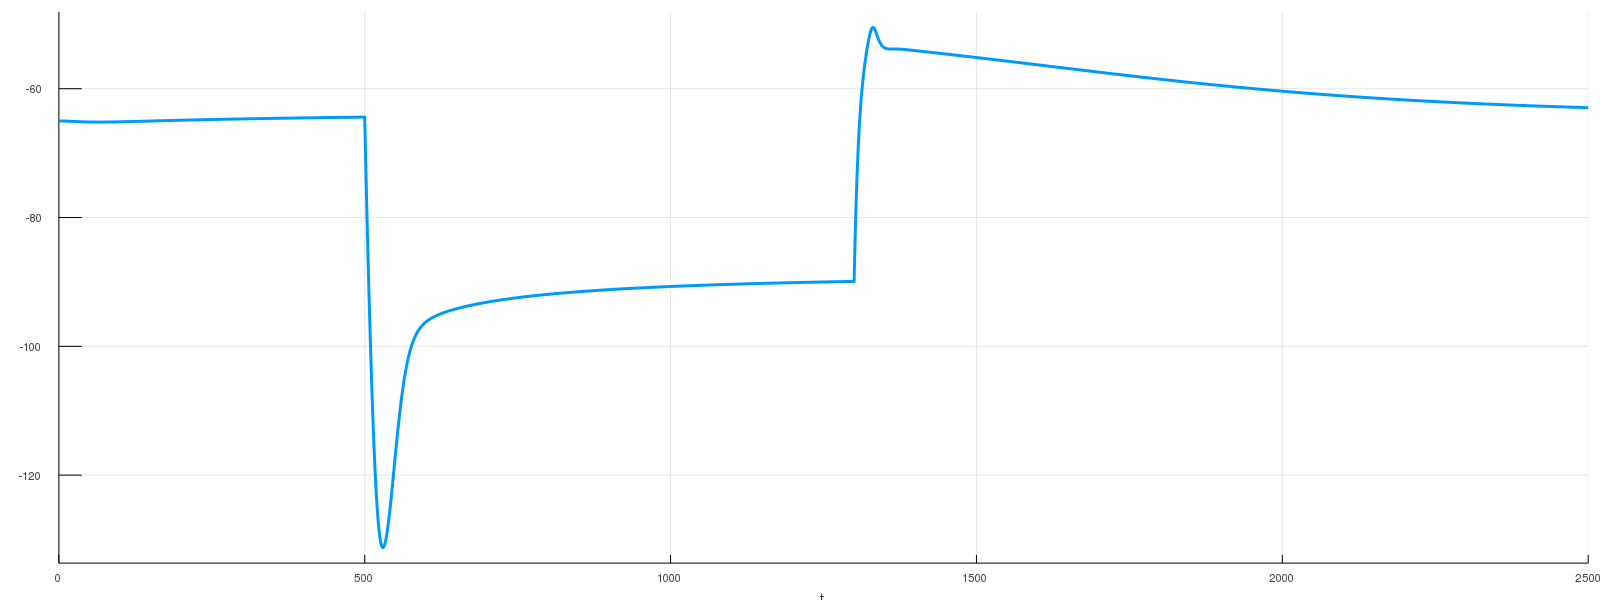

In [70]:
# running the simulation
_p = (E=(sodium=82.0, potassium=-81.0, ih=-46.0, leak=-65.0, syn=3.0), 
      stim=(start=500, step=-4.0, holding=0, dur=800, noise=0),)

# ih.h.Vhalf = -60.0
# HHModel.update!(ih)

tspan = (0.0, 2500.0)
v0 = -65.0
u0 = HHModel.setup_init(_model, v0)

prob = ODEProblem(_model_sim_cc, u0, tspan, _p)
@time sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

# preview voltage trace
plot(sol, vars=(1), legend=nothing)
# savefig("demo2.svg")

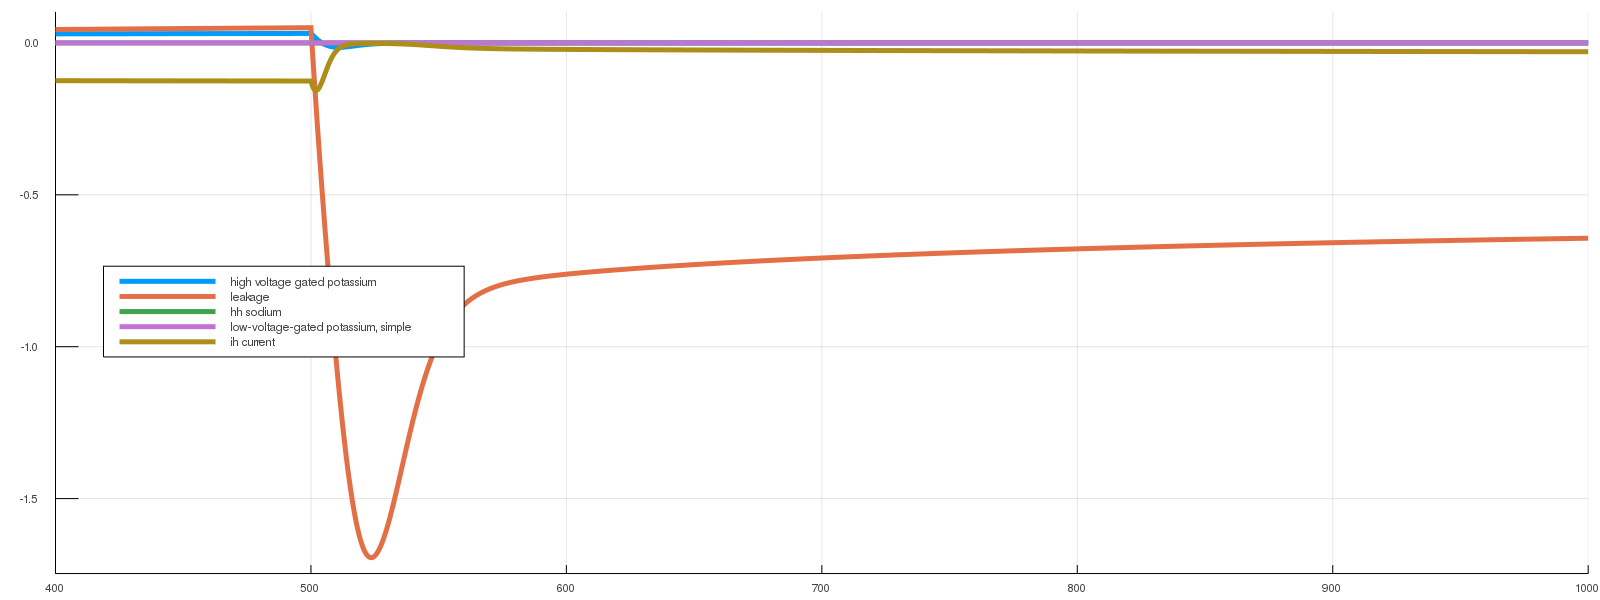

In [66]:
# preview current
_trange = 400:0.1:1000
_trace = HHModel.current_decompose(sol, _model, _trange, _p)
plot(xlim=(_trange[1], _trange[end]), legend=:left)
for (key, val) in _trace
    if key == "voltage"
        continue
    end
    plot!(_trange, val, label=key, linewidth=5)
end
plot!()
# savefig("demo2_current.svg")

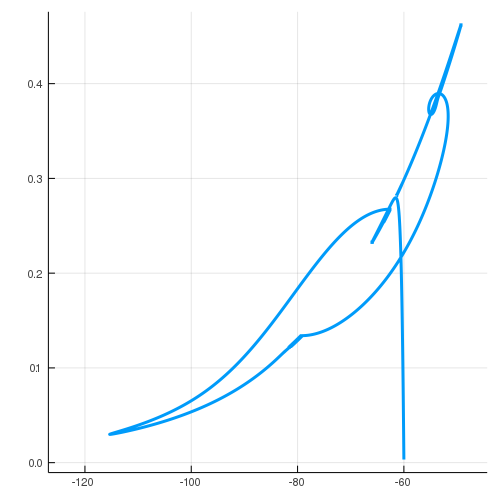

In [114]:
# preview dynamics

# dynamics between membrane potential and a particular kinetic variable
plot(sol, vars=(1,2), size=(500, 500), legend=nothing)

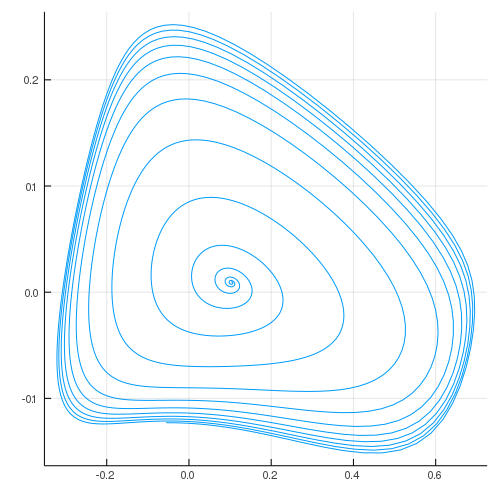

In [31]:
# PCA projection
_var_array = hcat(sol(800:0.1:1000).u...)[2:end-1, :]

_down = fit(PCA, _var_array);

_down_array = transform(_down, _var_array);

plot(_down_array[1,:], _down_array[2, :], size=(500, 500), legend=nothing)

---

  2.678453 seconds (18.04 M allocations: 1.917 GiB, 16.53% gc time)


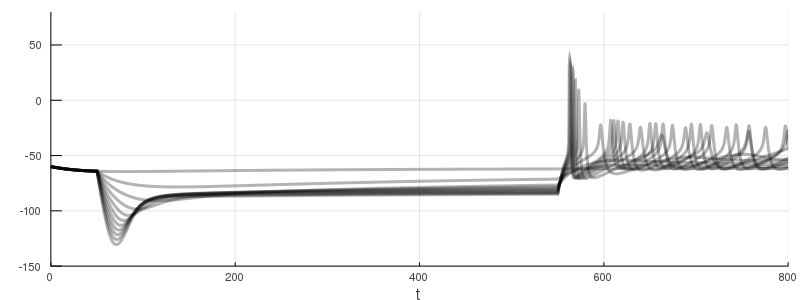

In [118]:
# sweep protocol

_current_steps = -5:0.5:0

plot(legend=nothing, ylim=(-150, 80), xlim=(190, 250))

@time for _i_step in _current_steps
    _p = (E=(sodium=81.27, potassium=-80.78, ih=-26, leak=-65, syn=3), 
      stim=(start=50, step=_i_step, dur=500, holding=0, noise=0),)
    prob = ODEProblem(_model_sim_cc, u0, tspan, _p)
    sol = solve(prob, Tsit5(), dt=0.1)

    plot!(sol, vars=(1), color=:black, alpha=0.3)
end

plot!()

  2.766710 seconds (12.51 M allocations: 1.443 GiB, 15.66% gc time)


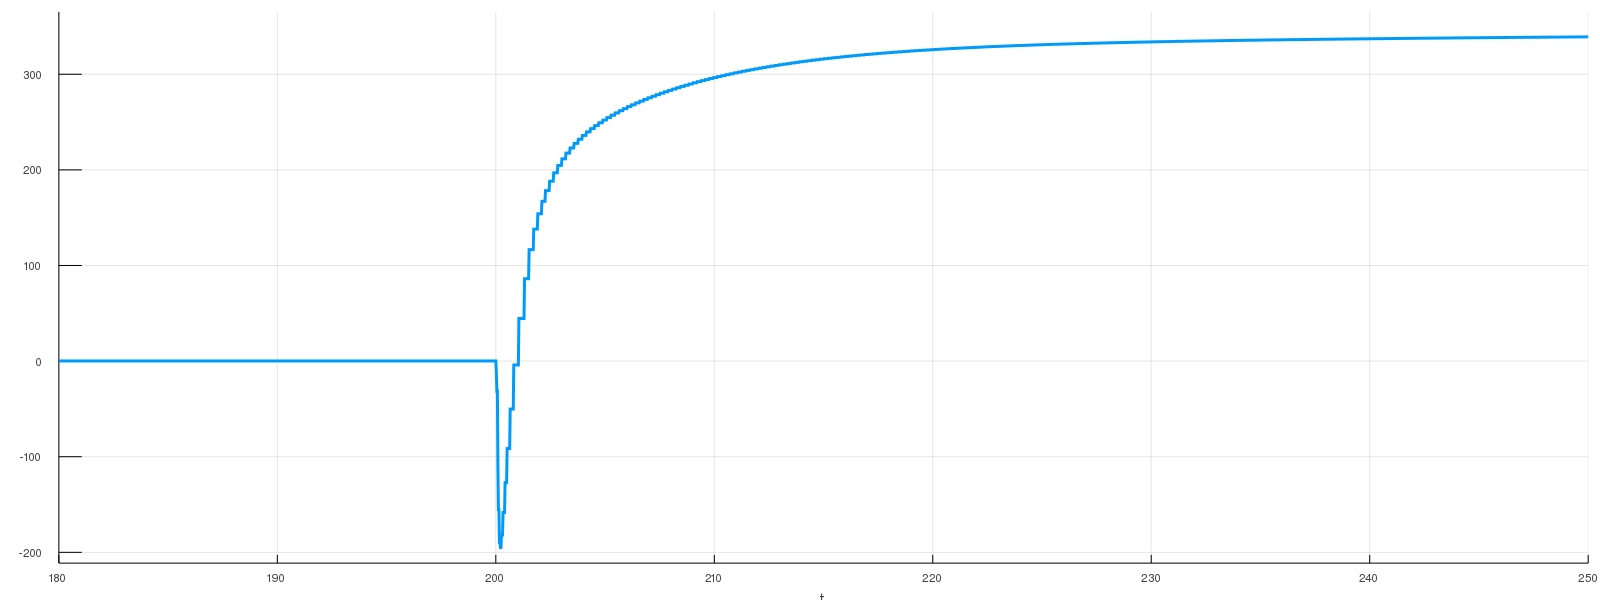

In [229]:
voltage_step = (t, param) -> begin
    (param.start < t)&(t < param.dur + param.start) ? param.step + param.noise * (rand()-0.5) : -60 + param.noise * (rand()-0.5)
end

_model_sim = HHModel.simpleVoltageClamp(_model, voltage_step, C=0.9)

# running the simulation
_p = (E=(sodium=81.27, potassium=-80.78, ih=-26.0, leak=-65.0, syn=3.0), 
      stim=(start=200, step=30, dur=1500, noise=0),)

tspan = (0.0, 2000.0)
v0 = -60.0
u0 = HHModel.setup_init(_model, v0)

prob = ODEProblem(_model_sim, u0, tspan, _p)
@time sol = solve(prob, Tsit5(), dt=0.01)

# preview current
plot(sol, vars=(length(u0)), legend=nothing, xlim=(180,250))
# savefig("demo2.svg")


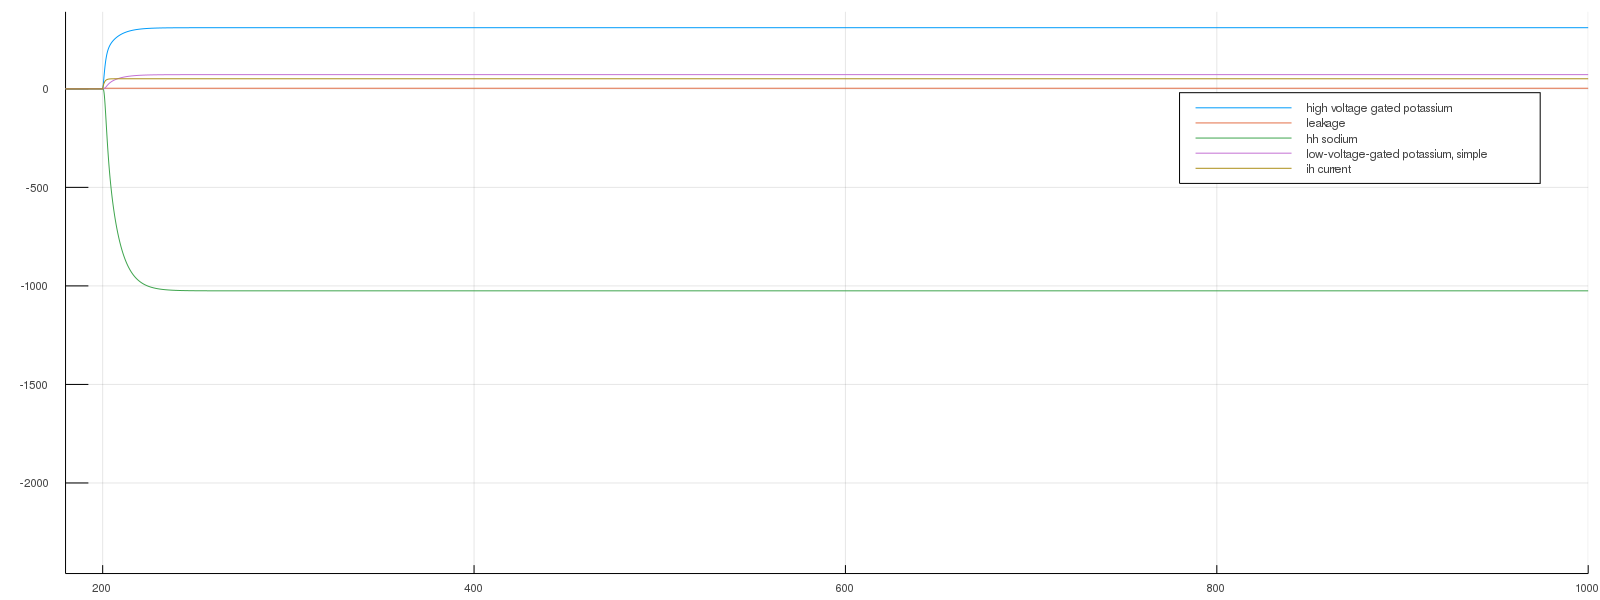

In [230]:
# preview current
_trange = 0:0.1:2000
_trace = HHModel.current_decompose(sol, _model, _trange, _p)
plot(xlim=(_trange[1], _trange[end]))
for (key, val) in _trace
    if key == "voltage"
        continue
    end
    plot!(_trange, val, label=key)
end
plot!(xlim=(180, 1000))
# savefig("demo2_current.svg")